# **Generated Content Detector Project: AI generated photos vs real photos**
# **Transfer Learning - Vision Transformer (ViT) Model**


## **Importing Libraries**

In [1]:
!pip install --upgrade torchinfo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from typing import List, Tuple
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer
import random
from sklearn.metrics import classification_report
print(torch.cuda.is_available())

True


## **Downloading the dataset**
###### The !gdown command downloads a specific file from Google Drive directly into the current working directory of the Jupyter notebook, using its unique file ID.




In [3]:
!gdown 1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL

Downloading...
From (original): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL
From (redirected): https://drive.google.com/uc?id=1u4xb45DdfP80kxJ20DV20qAGyhcDaCDL&confirm=t&uuid=8e845584-f6ff-4b42-972b-1934511e566d
To: /content/AI-face-detection-Dataset-v3.zip
100% 1.12G/1.12G [00:13<00:00, 82.3MB/s]


###### The !unzip command extracts the contents of the ZIP file above, decompressing the files into the current directory.

In [ ]:
!unzip /content/AI-face-detection-Dataset-v3.zip

## **Determining Optimal System Device for Performance: CPU vs. CUDA (VRAM)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## **Preparing Image Datasets with PyTorch.**
##### **- Training Data: 7,000 images (3500 AI + 3500 real) - 70%**
##### **- Testing Data: 2,000 images (1000 AI + 1000 real) - 20%**
##### **- Testing Data: 1,000 images (500 AI + 500 real) - 10%**

In [6]:
# Measure the time taken for the cell execution:
%%time

# Set up image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the specified directory
dataset = datasets.ImageFolder("/content/AI-face-detection-Dataset-v3/", transform=transform)

# Load previously saved indices or datasets if available:
try:
    with open('datasets.pkl', 'rb') as f:
        data = pickle.load(f)
        train_indices = data['train_indices']
        val_indices = data['val_indices']
        test_indices = data['test_indices']
        classes = data['classes']
except FileNotFoundError:
    print("No saved dataset found, proceeding with the current run.")

# If loading fails, do the following steps:

# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

# Prepare subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)  # Validation loader
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Retrieve class names
classes = dataset.classes   # ['ai', 'real']

# Output the number of samples in training, validation, and testing datasets
print("Train samples:", len(train_indices))
print("Validation samples:", len(val_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

# Save the datasets and indices:
with open('datasets.pkl', 'wb') as f:
    pickle.dump({
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices,
        'classes': classes
    }, f)

No saved dataset found, proceeding with the current run.
Train samples: 6996
Validation samples: 998
Test samples: 2002
Classes: ['AI', 'real_color']
CPU times: user 10min 20s, sys: 2.05 s, total: 10min 22s
Wall time: 2min 45s


## **Setting up a pretrained model - 'Vision Transformer (ViT) B-16'**

In [7]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Selects the best available weights
model = torchvision.models.vit_b_16(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 246MB/s]


## **Getting a summary of our model with torchinfo.summary()**
###### The Vision Transformer (ViT) B-16 model is an advanced architecture for image classification and vision tasks, utilizing a transformer framework to process visual data. It divides images into 16x16 pixel patches and employs self-attention mechanisms to capture relationships between them. With approximately 86 million parameters, it balances complexity and efficiency, delivering high performance without excessive resource usage. The ViT B-16 excels in visual recognition, generalizing effectively across various datasets, and is ideal for applications such as image classification and object detection, marking a significant advancement in computer vision.

In [8]:
summary(model=model,
        input_size=(8, 3, 224, 224), # The size of the input tensor (batch size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"], # Specifies the columns to display in the summary
        col_width=20, # Sets the width of the columns in the summary output
        row_settings=["var_names"]) # Includes variable names in the summary rows for clarity

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224]     [8, 1000]            768                  True
├─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [8, 197, 768]        [8, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [8, 197, 768]        [8, 197, 768]        --                   --
│    └─Sequential (layers)                                   [8, 197, 768]        [8, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]        [8, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]        [8, 197, 768

###### The Vision Transformer B-16 processes 224x224 pixel images in batches of 8, producing outputs for 1000 classes. It includes a convolutional layer that projects inputs to a 768-dimensional space, followed by 12 encoder blocks using self-attention mechanisms. A final linear layer outputs class probabilities. With 86,567,656 trainable parameters and approximately 1.39 billion multiply-add operations per forward pass, it exemplifies an effective balance of complexity and efficiency in image classification tasks.

## **Freezing All Layers of the Base Model Except the Last Layer**
###### Freezing all layers of the Vision Transformer model except the last layer during transfer learning helps retain the essential learned features from the pre-trained model, reducing the risk of overfitting, particularly with limited datasets. This strategy allows the model to focus on adapting the final layer, which is tailored to the new classification task, while preserving the foundational knowledge captured in the earlier layers. Additionally, it accelerates the training process and enhances stability in the early epochs, leading to more effective fine-tuning overall.

In [21]:
# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the classification head (the last layer)
for param in model.heads.parameters():
    param.requires_grad = True

# Unfreeze the last encoder layer
num_encoder_layers = len(model.encoder.layers)
for i in range(num_encoder_layers - 1, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

In [22]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of classes (one output unit for each class)
output_shape = len(classes)

# Recreate the classification head layer for VisionTransformer models
# The classification head is typically model.heads.head
model.heads.head = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=768, # The correct input features for ViT-B/16's head
                    out_features=output_shape, # Same number of output units as our number of classes
                    bias=True)).to(device)

In [23]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model,
        input_size=(8, 3, 224, 224), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224]     [8, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [8, 197, 768]        [8, 197, 768]        151,296              Partial
│    └─Dropout (dropout)                                     [8, 197, 768]        [8, 197, 768]        --                   --
│    └─Sequential (layers)                                   [8, 197, 768]        [8, 197, 768]        --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]        [8, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]        [

###### After freezing all but the last layer of the Vision Transformer model, the total parameters decreased from 86,567,656 to 85,800,194, reflecting a reduction in model complexity. The remaining 7,089,410 parameters are trainable, enabling adaptation to the specific task while preserving foundational knowledge. Despite this adjustment, memory usage and compute requirements for forward and backward passes remained similar, thereby enhancing training efficiency without compromising performance.

## **Training the model**

In [24]:
# Define the loss function for training
loss_fn = nn.CrossEntropyLoss() # This is used for multi-class classification

# Set up the optimizer for updating the model's parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent with momentum

# Alternative optimizer: Adam optimizer for adaptive learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
#ENGINE
"""
Contains functions for training and testing a PyTorch model.
"""

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy).
    For example:(0.1112, 0.8743)
    """
    # Put model in train mode to enable training features
    model.train()

    # Initialize train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through batches of data from the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # # Send data to the specified target device (GPU/CPU)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass: get predictions from the model
        y_pred = model(X)

        # 2. Calculate and accumulate loss using the loss function
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # Accumulate loss for average calculation

        # # 3. Optimizer zero grad: clear old gradients
        optimizer.zero_grad()

        # 4. Loss backward: compute gradients of loss with respect to model parameters
        loss.backward()

        # 5. . Optimizer step: update model parameters based on gradients
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader) # Average loss over batches
    train_acc = train_acc / len(dataloader) # Average accuracy over batches
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).
    For example: (0.0223, 0.8985)
    """
    # Put model in eval mode to deactivate dropout layers and batch norm behavior
    model.eval()

    # Initialize test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager to save memory during inference
    with torch.inference_mode():
        # Loop through DataLoader batches for testing
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the specified target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass: get predictions from the model
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item() # Accumulate loss for average calculation

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [26]:
# Set the random seeds for reproducibility in training
torch.manual_seed(42)  # Set seed for CPU
torch.cuda.manual_seed(42)  # Set seed for GPU

# Start the timer to measure training duration
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=trainloader,  # DataLoader for training data
                       test_dataloader=valloader, # DataLoader for validation/testing data
                       optimizer=optimizer, # Optimizer for model training
                       loss_fn=loss_fn, # Loss function to evaluate model performance
                       epochs=10, # Number of training epochs
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2807 | train_acc: 0.8834 | test_loss: 0.1756 | test_acc: 0.9518
Epoch: 2 | train_loss: 0.1747 | train_acc: 0.9338 | test_loss: 0.1473 | test_acc: 0.9570
Epoch: 3 | train_loss: 0.1552 | train_acc: 0.9406 | test_loss: 0.1368 | test_acc: 0.9528
Epoch: 4 | train_loss: 0.1364 | train_acc: 0.9485 | test_loss: 0.1779 | test_acc: 0.9248
Epoch: 5 | train_loss: 0.1259 | train_acc: 0.9525 | test_loss: 0.1269 | test_acc: 0.9567
Epoch: 6 | train_loss: 0.1173 | train_acc: 0.9543 | test_loss: 0.1117 | test_acc: 0.9619
Epoch: 7 | train_loss: 0.1062 | train_acc: 0.9605 | test_loss: 0.1002 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.0978 | train_acc: 0.9630 | test_loss: 0.0866 | test_acc: 0.9697
Epoch: 9 | train_loss: 0.0878 | train_acc: 0.9678 | test_loss: 0.0916 | test_acc: 0.9697
Epoch: 10 | train_loss: 0.0832 | train_acc: 0.9703 | test_loss: 0.1077 | test_acc: 0.9609
[INFO] Total training time: 601.255 seconds


## **Learning Curve**

In [27]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

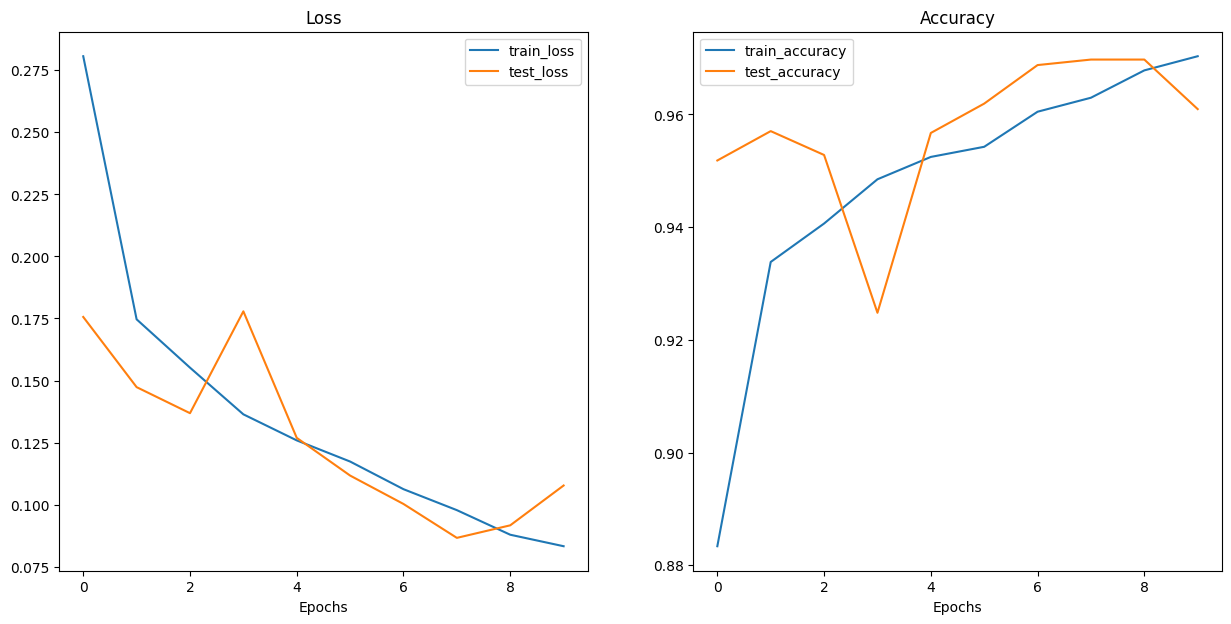

In [28]:
# Plot the loss curves of our model
plot_loss_curves(results)

###### The learning curves indicate that while the training loss decreases steadily and training accuracy improves significantly, the test loss remains consistently higher than the training loss, suggesting potential overfitting. The test accuracy shows fluctuations, indicating sensitivity to the test data and possible generalization issues. To address these concerns, implementing regularization techniques, considering data augmentation, and using early stopping could help improve model performance and robustness.

## **Validation Accuracy**

In [29]:
# Load the best saved model
# The 'Net' class is not defined, using the 'model' variable from previous cells.
best_model = model
# The model is already loaded and trained, so no need to load state dict again.
# best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_val_accuracy = correct / total
print(f"Final Validation Accuracy (best model): {final_val_accuracy:.4f}")

Final Validation Accuracy (best model): 0.9599


###### My final validation accuracy is 0.9599, which shows that my model performs very well on unseen data. This high accuracy indicates effective learning and good generalization, making it a strong candidate for practical applications.

## **Testing the Network on Test Data**


#### Preparing and Predicting Test Images


In [30]:
model.eval() # Set the model to evaluation mode

dataiter = iter(testloader)  # Create an iterator for the test data loader
images, true_labels = next(dataiter)  # Get a batch of images and their true labels

images = images.to(device)  # Move images to the appropriate device

# Perform a forward pass and get predictions without calculating gradients
with torch.no_grad():
    outputs = model(images)

_, predicted_labels = torch.max(outputs, 1) # Get the predicted class indices

print("Retrieved a batch of test images and generated predictions.")
print(f"Number of images in batch: {len(images)}")
print(f"True labels (first 10): {true_labels[:10].tolist()}")
print(f"Predicted labels (first 10): {predicted_labels[:10].tolist()}")

Retrieved a batch of test images and generated predictions.
Number of images in batch: 32
True labels (first 10): [0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
Predicted labels (first 10): [0, 0, 0, 1, 1, 1, 0, 1, 0, 0]


#### Displaying Images with Actual and Predicted Labels


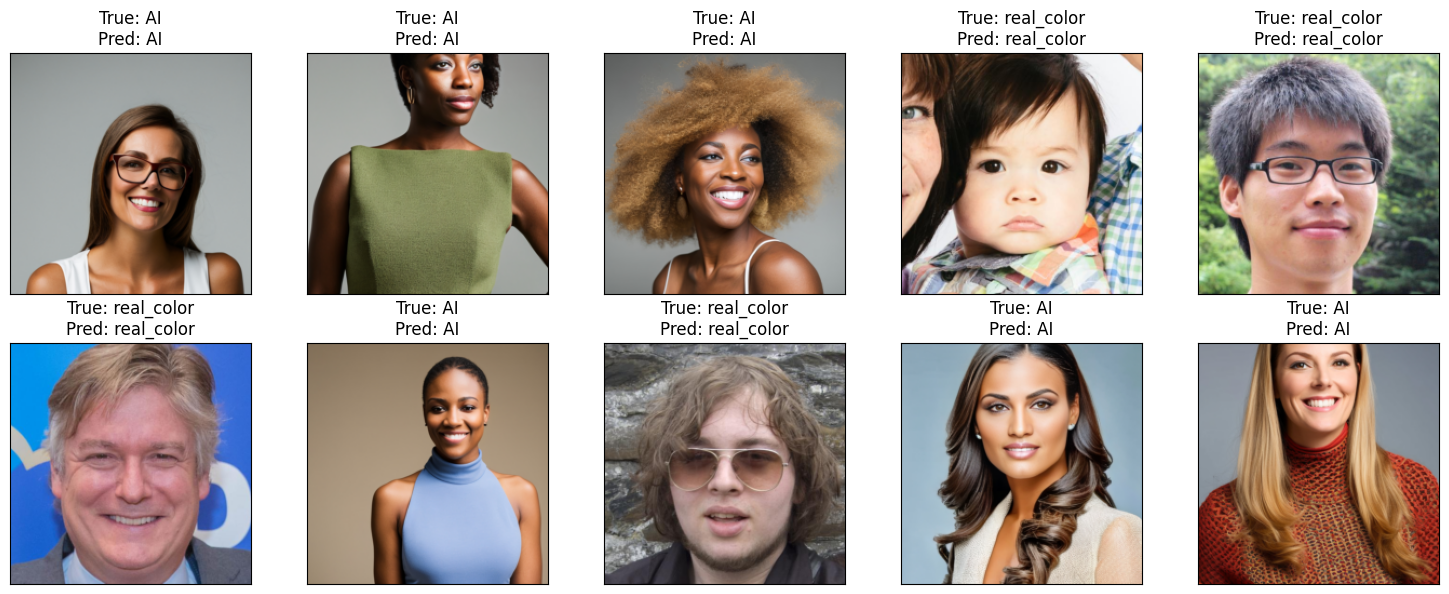

In [31]:
num_display = 10

fig = plt.figure(figsize=(15, 6))

for idx in range(num_display):
    ax = fig.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])

    # Unnormalize the image and transpose dimensions
    img_display = images[idx].cpu().numpy()
    img_display = img_display / 2 + 0.5
    img_display = np.transpose(img_display, (1, 2, 0))

    # Display the image
    ax.imshow(img_display)

    # Set title with true and predicted labels
    ax.set_title(f"True: {classes[true_labels[idx]]}\nPred: {classes[predicted_labels[idx]]}")

plt.tight_layout()
plt.show()

## **Evaluating Network Performance on the Entire Dataset**
### **Overall Accuracy**

In [32]:
correct = 0  # Initialize a counter for correctly classified images
total = 0    # Initialize a counter for the total number of images

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:  # Iterate through batches of test data
        images, labels = data  # Get images and their corresponding labels

        # Move inputs to the appropriate device for processing
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by passing images through the network
        outputs = model(images)

        # Determine the predicted class by finding the index of the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Update the total number of images processed
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print the accuracy of the network on the test dataset
accuracy = 100 * correct / total if total > 0 else 0  # Prevent division by zero
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')  # Print accuracy formatted to two decimal places

Accuracy of the network on the test images: 96.95 %


###### The accuracy of the network on the test images is 96.95%, demonstrating that the model generalizes well to new data and effectively captures the underlying patterns in the dataset. This strong performance reinforces the model's reliability for practical use.

### **Classification Report**

In [33]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=classes)

# Print the report
print(report)

              precision    recall  f1-score   support

          AI       0.96      0.98      0.97      1001
  real_color       0.98      0.96      0.97      1001

    accuracy                           0.97      2002
   macro avg       0.97      0.97      0.97      2002
weighted avg       0.97      0.97      0.97      2002



###### The model demonstrates strong performance with an overall accuracy of 97% on the test set of 2002 samples. Both classes, AI and Real, exhibit high precision (0.96 and 0.98, respectively) and recall (0.98 for AI and 0.96 for Real Color), resulting in balanced F1-scores of 0.97 for both. The macro and weighted averages further reinforce the model's reliability, indicating consistent effectiveness in distinguishing between the two classes.

### **Confusion Matrix**

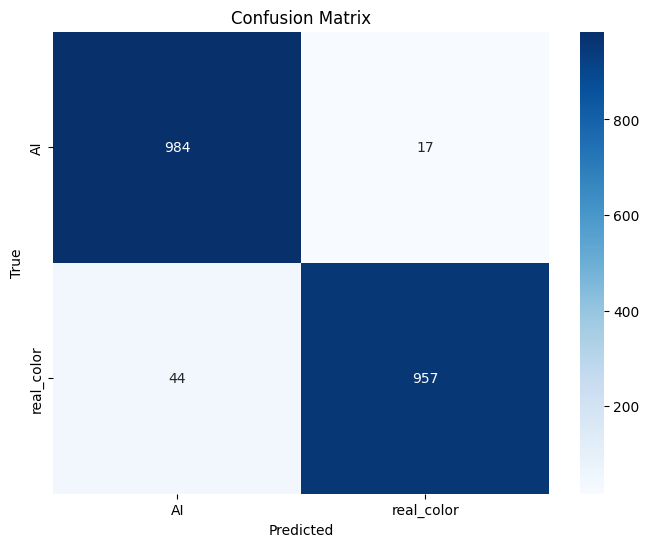

In [34]:
# Ensure the model is in evaluation mode and on the correct device
model.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###### The confusion matrix indicates strong model performance, with 984 true positives for the AI class and 957 for the real class. There are 44 false negatives, where real_color was misclassified as AI, and 17 false positives, where AI was incorrectly labeled as real_color. Overall, the model effectively distinguishes between the two categories but could benefit from improvements in reducing false negatives for the real class.

#### **Summary:** The model exhibits impressive performance across various metrics, achieving an overall accuracy of 97% on the test set of 2002 samples. Precision and recall are high, with the AI class scoring 0.96 and 0.98, respectively, while the real_color class scores 0.98 and 0.96. Both classes have an F1-score of 0.97, indicating a balanced performance. The confusion matrix further supports these results, showing 984 true positives for AI and 957 for real_color, with 44 false negatives and 17 false positives. Overall, the model demonstrates strong classification capabilities but could improve in reducing false negatives for the real_color class.